In [1]:
%matplotlib inline
from __future__ import division
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import utils
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from time import time

In [2]:
visitors, events, devices, url_categories = utils.load_data(event_categories=True)
#categorized_events = utils.categorize_events(events, url_categories)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (5,6,7,8,11,12,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Use Cases
- ok
#### Pharma/Device Branded Research
- Visits a pharma or medical device site for a specific brand
#### Pharma/Device Unbranded Research
- Visits a pharma or medical device unbranded education site
#### Publication Research
- Visits a publication site
#### Professional Social Media / Career
- Visits a professional social media or recruitment site
#### Education / Tools
- Visits a site focused on educational resources and tools to better serve patients
#### Mixed Visits
- A combination of anything above; can flesh out specific combinations if they are frequent enough (ex: social + publication)

In [18]:
def define_use_case(event):
    if event.site_category == 'Publisher':
        return 'Publication Research'
    elif event.site_category in ['Reference Tool', 'Medical Education', 'Multi-Channel Marketing']:
        return 'Education/Tools'
    elif event.site_category in ['Pharma', 'Med Device']:
        if event.site_sub_category.strip() in ['Branded HCP', 'Branded Consumer']:
            return 'Branded Pharma'
        elif event.site_sub_category.strip() in ['Unbranded HCP', 'Unbranded Consumer']:
            return 'Unbranded Pharma'
    elif event.site_category in ['Professional Social', 'Medical Association', 'Recruiter']:
        return 'Professional/Social Media'
    else:
        return 'Other'

In [364]:
def define_use_case_limited(event):
    if event.site_category in ['Publisher', 'Reference Tool', 'Medical Education', 'Multi-Channel Marketing']:
        return 'publications_ed_tools'
    elif event.site_category in ['Pharma', 'Med Device']:
        return 'pharma_device'
    elif event.site_category in ['Professional Social', 'Medical Association', 'Recruiter']:
        return 'professional_social_media'
    else:
        return 'other'

In [3]:
publisher_tools = ['Publisher', 'Reference Tool', 'Medical Education', 'Multi-Channel Marketing']
pharma = ['Pharma', 'Med Device']
social = ['Professional Social', 'Medical Association', 'Recruiter']

In [4]:
events['use_case'] = ''
events.loc[events.site_category.isin(publisher_tools), 'use_case'] = 'publications_ed_tools'
events.loc[events.site_category.isin(pharma), 'use_case'] = 'pharma_device'
events.loc[events.site_category.isin(social), 'use_case'] = 'professional_social_media'
events.loc[events.use_case=='', 'use_case'] = 'other'

In [332]:
events['use_case'] = events.apply(lambda x: define_use_case_limited(x), axis=1)

In [5]:
events.use_case.value_counts()

publications_ed_tools        1603272
pharma_device                 140356
professional_social_media      83496
other                          35462
Name: use_case, dtype: int64

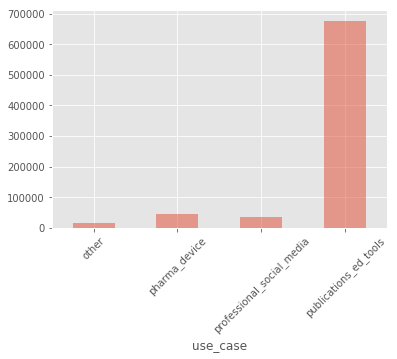

In [6]:
events[events.use_case<>'publication_research'].groupby('use_case').session_id.nunique().plot.bar(rot=45, alpha=0.5)

In [7]:
sessions = events[events.use_case <> 'Other'].groupby('session_id').event_id.count().reset_index()
sessions = sessions.rename(columns={'event_id':'page_views'})
event_sessions = events.drop_duplicates('session_id')
event_sessions = pd.merge(event_sessions, sessions, on='session_id')
event_sessions = pd.merge(visitors, event_sessions, on='dg_id')
event_sessions.head()

,visitor_id,dg_id,identity_type,professional_designation,npi_number,primary_specialty,primary_specialty_group,secondary_specialty,secondary_specialty_group,first_name,...,fragment,reason,category_url,site_category,site_sub_category,disease_category,disease,pharma_firm,use_case,page_views
0,140,0000124213,POI,POI,NaN,NaN,NaN,NaN,NaN,KIMBERLY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,1
1,3538,R0000000026,POI,Nurse,NaN,NaN,NaN,NaN,NaN,SHARON,...,NaN,NaN,www.ReachMD.com,Multi-Channel Marketing,Multi Topic,Multiple,NaN,NaN,publications_ed_tools,1
2,3562,R0000000098,POI,Nurse,NaN,NaN,NaN,NaN,NaN,KAREN,...,NaN,NaN,www.medicalnewstoday.com,Publisher,Multi Topic,Multiple,NaN,NaN,publications_ed_tools,1
3,3653,R0000000358,POI,Nurse,NaN,NaN,NaN,NaN,NaN,PROSPECTIVE STUDENT,...,NaN,NaN,www.healthjobsnationwide.com,Recruiter,Multi Topic,Multiple,NaN,NaN,professional_social_media,1
4,3783,R0000000651,POI,Nurse,NaN,NaN,NaN,NaN,NaN,PROSPECTIVE STUDENT,...,NaN,NaN,www.consultant360.com,Publisher,Multi Topic,Multiple,NaN,NaN,publications_ed_tools,2


In [34]:
tableau_sessions = event_sessions[['timestamp', 'dg_id', 'npi_number', 'primary_specialty', 'site_category', 'site_sub_category', 'disease_category', 'disease', 'pharma_firm', 'use_case', 'page_views']]

In [38]:
tableau_sessions.to_csv('../data/use_case_sessions.csv')

In [230]:
tableau_sessions.head()

,timestamp,dg_id,npi_number,primary_specialty,site_category,site_sub_category,disease_category,disease,pharma_firm,use_case,page_views
0,2017-02-14 23:29:52.100,0000124213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,1
1,2017-02-04 12:44:07.660,R0000000026,NaN,NaN,Multi-Channel Marketing,Multi Topic,Multiple,NaN,NaN,Education/Tools,1
2,2017-03-17 13:20:51.610,R0000000098,NaN,NaN,Publisher,Multi Topic,Multiple,NaN,NaN,Publication Research,1
3,2017-04-09 12:11:33.693,R0000000358,NaN,NaN,Recruiter,Multi Topic,Multiple,NaN,NaN,Professional/Social Media,1
4,2017-05-03 15:40:07.033,R0000000651,NaN,NaN,Publisher,Multi Topic,Multiple,NaN,NaN,Publication Research,2


In [8]:
personas = event_sessions.groupby('dg_id').use_case.apply(list).reset_index()
personas['total_sessions'] = personas.use_case.apply(lambda x: len(x))
personas['use_case_counts'] = personas.use_case.apply(lambda x: Counter(x))

In [268]:
single_use_case = personas[personas.use_case_counts.apply(lambda x: len(x))==1]
multi_use_case = personas[personas.use_case_counts.apply(lambda x: len(x))>1]

In [9]:
many_or_done = personas[personas.total_sessions>=5]

In [10]:
len(many_or_done)/len(personas)

0.21018889428959323

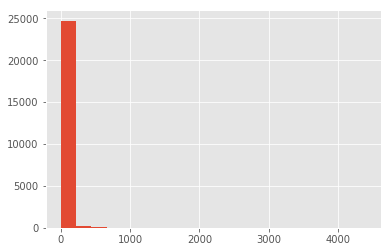

In [11]:
many_or_done.total_sessions.hist(bins=20)

In [258]:
single_use_case.total_sessions.describe()

count    91102.000000
mean         3.105311
std         11.014518
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        801.000000
Name: total_sessions, dtype: float64

In [269]:
single_use_case['single_use_case'] = single_use_case.use_case_counts.apply(lambda x: x.items()[0][0])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [270]:
single_use_case.single_use_case.value_counts()

publication_research    44003
education_tools         32908
social_media             6588
branded                  5515
other                    1984
unbranded                 104
Name: single_use_case, dtype: int64

In [195]:
personas['pharma'] = personas.use_case_counts.apply(lambda x: x['branded'] + x['unbranded'])

In [209]:
personas = pd.merge(personas, dg_phirms[['dg_id', 'phirm_counts']], on='dg_id', how='left')

In [231]:
personas['number_use_cases'] = personas.use_case_counts.apply(lambda x: len(x))

In [312]:
len(personas[personas.total_sessions<=3])/len(personas)

0.7293510324483776

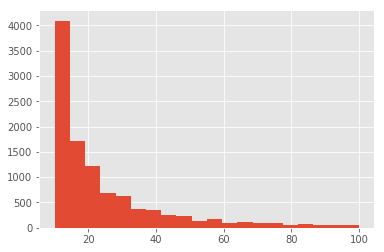

In [327]:
personas[(personas.total_sessions>=10)&(personas.total_sessions <= 100)].total_sessions.hist(bins=20)

In [316]:
events[events.dg_id=='U082239426'][['session_id', 'timestamp']]

,session_id,timestamp
1577057,3661872c-b9f3-45ee-b7a6-6b7d7f46de71,2017-03-16 18:26:21.873
1577058,3661872c-b9f3-45ee-b7a6-6b7d7f46de71,2017-03-16 18:26:32.067
1577059,f7f31c2f-3bc5-4b15-82df-9fee479eae9b,2017-04-11 14:26:23.963
1577060,f7f31c2f-3bc5-4b15-82df-9fee479eae9b,2017-04-11 14:26:29.223


In [373]:
vectorizer = CountVectorizer(min_df=1)
#X = vectorizer.fit_transform(personas.use_case.apply(lambda x: ', '.join(x)).as_matrix())
#Xs = vectorizer.fit_transform(single_use_case.use_case.apply(lambda x: ', '.join(x)).as_matrix())
#Xt = vectorizer.fit_transform(personas[personas.number_use_cases>1].use_case.apply(lambda x: ', '.join(x)).as_matrix())
Xm = vectorizer.fit_transform(many_or_done.use_case.apply(lambda x: ', '.join(x)).as_matrix())
km = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1, verbose=1)

t0 = time()
km.fit(Xm)
print ("done in %0.3fs" % (time() - t0))
print()

many_or_done['cluster'] = km.labels_

Initialization complete
Iteration  0, inertia 43570067.000
Iteration  1, inertia 43142255.163
Iteration  2, inertia 43030816.718
Iteration  3, inertia 42842137.476
Iteration  4, inertia 42752009.685
Iteration  5, inertia 42742954.892
Iteration  6, inertia 42742066.413
Iteration  7, inertia 42741587.711
Iteration  8, inertia 42741516.904
Converged at iteration 8: center shift 0.000000e+00 within tolerance 1.611878e-01
done in 0.393s



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [374]:
many_or_done.cluster.value_counts()

0    24645
2      410
1       26
Name: cluster, dtype: int64

In [376]:
i = 0
while i < 10:
    print(many_or_done[many_or_done.cluster==1].sample().use_case_counts.item())
    i+=1

Counter({'publications_ed_tools': 1064, 'other': 48, 'pharma_device': 16, 'professional_social_media': 5})
Counter({'publications_ed_tools': 1238, 'pharma_device': 47, 'professional_social_media': 21, 'other': 5})
Counter({'publications_ed_tools': 1424, 'pharma_device': 65, 'professional_social_media': 12, 'other': 10})
Counter({'publications_ed_tools': 1064, 'other': 48, 'pharma_device': 16, 'professional_social_media': 5})
Counter({'publications_ed_tools': 1565, 'pharma_device': 36, 'professional_social_media': 32, 'other': 24})
Counter({'publications_ed_tools': 4295, 'other': 61, 'pharma_device': 25, 'professional_social_media': 7})
Counter({'publications_ed_tools': 2498, 'pharma_device': 12, 'professional_social_media': 1, 'other': 1})
Counter({'publications_ed_tools': 1082, 'pharma_device': 12, 'professional_social_media': 2})
Counter({'publications_ed_tools': 1258, 'other': 21, 'pharma_device': 4})
Counter({'publications_ed_tools': 1183, 'pharma_device': 43, 'professional_social_

In [279]:
single_use_case.groupby('cluster').total_sessions.agg(['mean', 'count'])

,mean,count
cluster,,
0,2.461435,90329
1,241.068966,87
2,801.000000,1
3,56.623358,685


In [280]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(Xs.toarray())

In [94]:
import random
random.sample(range(pca.shape[0]), 1)

[36895]

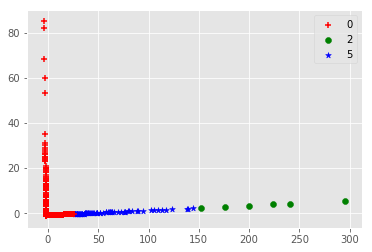

In [281]:
import matplotlib.pyplot as plt
for i in random.sample(range(pca.shape[0]), 10000):
    if km.labels_[i] == 0:
        c1 = plt.scatter(pca[i,0],pca[i,1],c='r', marker='+')
    elif km.labels_[i] == 1:
        c2 = plt.scatter(pca[i,0],pca[i,1],c='g', marker='o')
    elif km.labels_[i] == 3:
        c3 = plt.scatter(pca[i,0],pca[i,1],c='b',marker='*') 
plt.legend([c1, c2, c3], ['0', '2', '5'])
plt.figure(figsize=(20,10))
plt.show()

In [12]:
import plotly.plotly as py

In [14]:
many_or_done['pharma'] = many_or_done.use_case_counts.apply(lambda x: x['pharma_device'])
many_or_done['publications'] = many_or_done.use_case_counts.apply(lambda x: x['publications_ed_tools'])
many_or_done['social'] = many_or_done.use_case_counts.apply(lambda x: x['professional_social_media'])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [18]:
df = many_or_done[many_or_done.total_sessions<=50][['pharma', 'publications', 'social']]

In [21]:
scatter = dict(
    mode = "markers",
    name = "y",
    type = "scatter3d",    
    x = df['pharma'], y = df['publications'], z = df['social'],
    marker = dict( size=2, color="rgb(23, 190, 207)" )
)
clusters = dict(
    alphahull = 7,
    name = "y",
    opacity = 0.1,
    type = "mesh3d",    
    x = df['pharma'], y = df['publications'], z = df['social']
)
layout = dict(
    title = '3d point clustering',
    scene = dict(
        xaxis = dict( zeroline=False ),
        yaxis = dict( zeroline=False ),
        zaxis = dict( zeroline=False ),
    )
)
fig = dict( data=[scatter, clusters], layout=layout )
# Use py.iplot() for IPython notebook
py.iplot(fig, filename='3d point clustering')

In [423]:
Xm = vectorizer.fit_transform(many_or_done[many_or_done.total_sessions <= 40].use_case.apply(lambda x: ', '.join(x)).as_matrix())

In [424]:
Xmt = Xm.transpose()

In [427]:
%matplotlib osx

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

x =Xmt[3].toarray()
y =Xmt[1].toarray()
z =Xmt[2].toarray()



ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Publisher')
ax.set_ylabel('Pharma')
ax.set_zlabel('Social/Professional')

plt.show()